In [1]:
import numpy as np

import pandas as pd

import seaborn as sns
import  matplotlib.pyplot as plt

from lib.mcalc import gcf2ann, spike2bin, spikeCoin
from lib.mviz import visSpk

### Trial-by-trial variability

In [2]:
# data setting
D = 3.0
recpath = './data/var-D%.1f'%D
epoch = 10
T, dt = 2500, 0.1
Nm = 10000

Nfs = np.array([0, 100, 200, 300, 400, 600, 800, 1000])
Ws = np.array([-0.01, 0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25])

extract = True

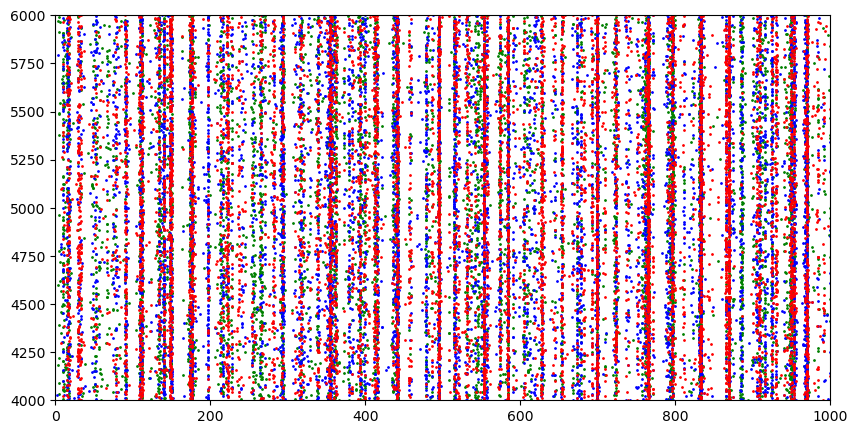

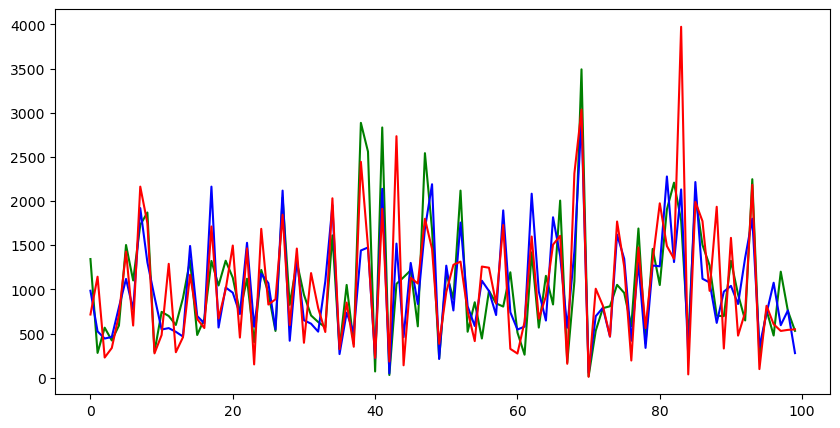

In [4]:
Nf = 100
W = 0.1

label = '/Nf%d-W%.2f/'%(Nf, W)
data = np.load(recpath + label + 'spk.npz')
es, ts = data.f.arr_0, data.f.arr_1

colors = ['green', 'blue', 'red']

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)
    plt.scatter(ts[idx]-ta, es[idx], s=1, c=c)
    plt.xlim(0, 1000)
    plt.ylim(4000, 6000)
plt.show()

if Nf > 0:
    nNums = [Nm, Nf]
else:
    nNums = [Nm, 1]
    
binsize = 20

plt.figure(figsize=(10, 5))
for e, c in enumerate(colors):
    ta, tb = e*T+500, (e+1)*T
    idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

    idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
    tmBins = np.arange(0, T+1-500, binsize)
    rates = np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]
    
    plt.plot(rates[:,0], c=c)
plt.show()

In [11]:
if extract:
    #  extract data from raw recordings
    frames = []
    binsize = 5
    for Nf in Nfs:
        if Nf > 0:
            nNums = [Nm, Nf]
        else:
            nNums = [Nm, 1]
        for W in Ws:
            label = '/Nf%d-W%.2f/'%(Nf, W)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # processing data
            rates = []
            for e in np.arange(0, epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.concatenate([[0], np.cumsum(nNums)]) + 1
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0])
            rates = np.array(rates)[:,:,0]
            
            # fano factor
            fanos = rates.var(axis=0)/rates.mean(axis=0);
            frames.append([Nf, W, np.mean(rates*1e3/Nm/binsize), np.mean(fanos[~np.isnan(fanos)])])

    colname = ['Nf', 'Win', 'rout', 'Fano']
    stats = pd.DataFrame(np.array(frames), columns=colname)

    np.savez('./exp/var/stats-D%.1f.npz'%D, np.array(frames))
    stats.to_csv('./exp/var/stats-D%.1f.csv'%D)

/var/folders/32/1rfbx39j19j6ff9b4l5xgn3m0000gn/T/ipykernel_79822/2170144172.py:28: RuntimeWarning: invalid value encountered in divide
  fanos = rates.var(axis=0)/rates.mean(axis=0);


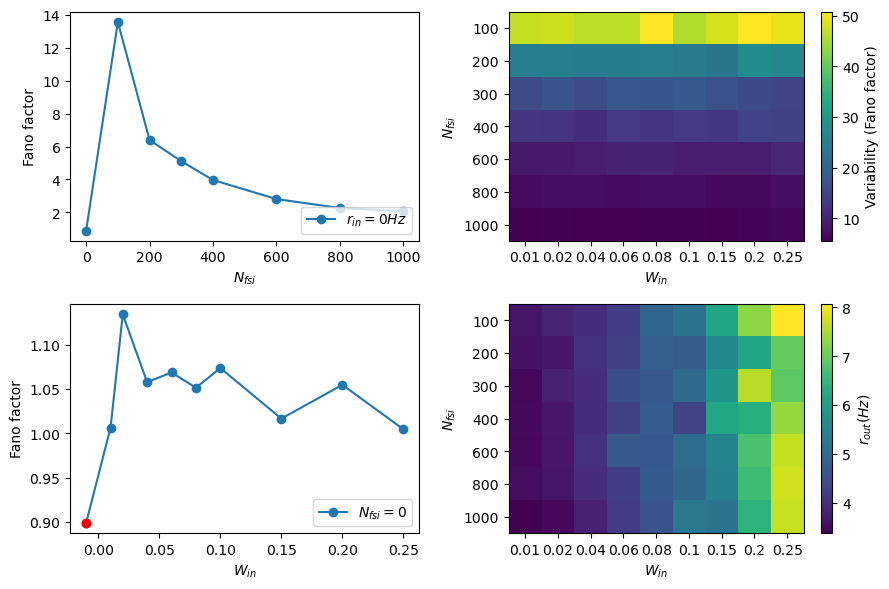

In [12]:
# load extracted data
stats = pd.read_csv('./exp/var/stats-D%.1f.csv'%D)
fanos = stats['Fano'].to_numpy()
rates = stats['rout'].to_numpy()
fig_fano = np.reshape(fanos, newshape=(len(Nfs), len(Ws)));
fig_rate = np.reshape(rates, newshape=(len(Nfs), len(Ws)));

# plot
fig, axes = plt.subplots(2,2,figsize=(9,6))

ax = axes[0,0]
ax.plot(Nfs, fig_fano[:,0], 'o-', label=r'$r_{in}=0Hz$')
ax.set_xlabel(r'$N_{fsi}$')
ax.set_ylabel('Fano factor')
ax.legend(loc='lower right')

ax = axes[1,0]
ax.plot(Ws, fig_fano[0], 'o-', label=r'$N_{fsi}=0$')
ax.plot(Ws[0], fig_fano[0,0], 'ro')
ax.set_xlabel(r'$W_{in}$')
ax.set_ylabel('Fano factor')
ax.legend(loc='lower right')

ax = axes[1,1]
im = ax.imshow(fig_rate[np.ix_(np.arange(len(Nfs)-1)+1, np.arange(len(Ws)-1)+1)])
ax.set_xlabel(r'$W_{in}$')
ax.set_xticks(np.arange(len(Ws)-1), Ws[1:]);
ax.set_ylabel(r'$N_{fsi}$')
ax.set_yticks(np.arange(len(Nfs)-1), Nfs[1:]);
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label(r'$r_{out}(Hz)$')

ax = axes[0,1]
im = ax.imshow(fig_fano[np.ix_(np.arange(len(Nfs)-1)+1, np.arange(len(Ws)-1)+1)])
ax.set_xlabel(r'$W_{in}$')
ax.set_xticks(np.arange(len(Ws)-1), Ws[1:]);
ax.set_ylabel(r'$N_{fsi}$')
ax.set_yticks(np.arange(len(Nfs)-1), Nfs[1:]);
cbar = plt.colorbar(im, fraction=0.046)
cbar.set_label('Variability (Fano factor)')

plt.tight_layout()
plt.savefig('./plot/var.pdf', bbox_inches='tight')

### Temporal correlation

In [3]:
# data setting
Ds = [1.0, 2.0, 3.0]
D = Ds[-1]
recpath = './data/cor-D%.1f'%D
epoch = 10
T, dt = 2500, 0.1
Nm = 5000

# Nfs = np.array([0, 100, 200, 300, 400, 600, 800, 1000])
Nfs = np.array([0, 100, 200, 300, 400, 800])
Ws = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25])
Bs = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 0.9])

In [4]:
# extract data from raw recordings
frames = []
binKernel = np.ones(int(5 / dt))
grpsize = 20
binsize = 20
for Nf in Nfs:
    if Nf > 0:
        nNums = [Nm, Nm, Nf]
    else:
        nNums = [Nm, Nm, 1]
    for W in Ws:
        for B in Bs:
            label = '/Nf%d-W%.2f-B%.2f/'%(Nf, W, B)
            data = np.load(recpath + label + 'spk.npz')
            es, ts = data.f.arr_0, data.f.arr_1
            data.close()

            # spikes
            mask = (es > Nm-100) & (es <= Nm+100) & (ts < T*3)
            visSpk(ts[mask], es[mask]-Nm+100, path='./plot/cor-D%.1f'%D + label + 'spk/spk')

            # processing data
            rates = []
            corrs = []
            for e in range(epoch):
                ta, tb = e*T+500, (e+1)*T
                idx = (ts>=ta) & (ts<tb) & (es<=2*Nm)

                idBins = np.arange(1, 2*Nm+2, grpsize)
                tmBins = np.arange(0, T+1-500, binsize)
                rates.append(np.histogram2d(ts[idx]-ta, es[idx], bins=[tmBins, idBins])[0]*1e3/binsize/grpsize)

                coV = np.corrcoef(rates[-1].T)
                np.fill_diagonal(coV, 0.)

                ng = int(Nm/grpsize)
                ix = np.arange(0, ng)
                corrs.append([   (np.sum(coV[np.ix_(ix, ix)])/ng/(ng-1) + np.sum(coV[np.ix_(ix+ng, ix+ng)])/ng/(ng-1))/2,
                                np.sum(coV[np.ix_(ix, ix+ng)])/ng/ng])

            # output correlations
            corrs = np.array(corrs)
            frames.append([Nf, W, B, corrs[:,0].mean(), corrs[:,1].mean()])

colname = ['Nf', 'Win', 'Bin', 'Wout', 'Bout']
stats = pd.DataFrame(np.array(frames), columns=colname)

np.savez('./exp/cor/stats-D%.1f.npz'%D, np.array(frames))
stats.to_csv('./exp/cor/stats-D%.1f.csv'%D)

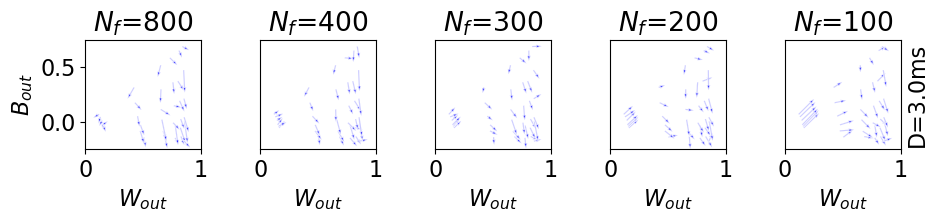

In [11]:
# plot font size
plt.rcParams.update({'font.size': 16})

Nfs = np.array([0, 100, 200, 300, 400, 800])

fig,axes = plt.subplots(1, len(Nfs)-1, figsize=(10, 2.5), sharex=True)
# load extracted data
stats = pd.read_csv('./exp/cor/stats-D%.1f.csv'%D)
cors = stats[['Nf', 'Wout', 'Bout']]

va = 0
wa, ba = cors.loc[cors['Nf']==va, 'Wout'], cors.loc[cors['Nf']==va, 'Bout']
for j, vb in enumerate(np.flip(Nfs[1:])):
    wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']
    ax = axes[j]
    
    # x-axis setting
    ax.set_title(r'$N_f$=%d'%vb)
    ax.set_xlabel(r'$W_{out}$') 

    # y-axis setting
    if j == 0:
        ax.set_ylabel(r'$B_{out}$') 
    elif j <= len(Nfs)-3:
        ax.set_yticks([])
    else:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_yticks([])
        ax.set_ylabel('D=%.1fms'%D)

    # xy range
    ax.set_xlim(0, 1.0)
    ax.set_ylim(-0.25, 0.75)

    # plot
    for x, y, xx, yy in zip(wa, ba, wb, bb):
        ax.arrow(x, y, xx-x, yy-y, width=0.01, edgecolor='w', facecolor='b', alpha=0.75);
plt.tight_layout()
plt.savefig('./plot/cor.pdf', bbox_inches='tight')

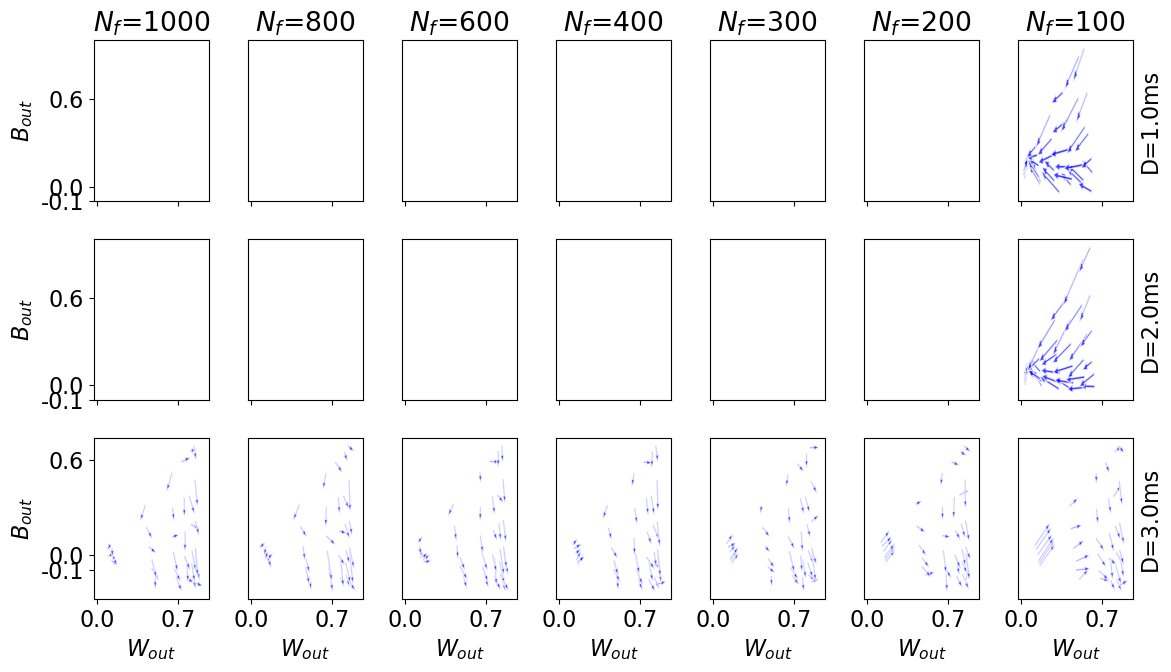

In [6]:
# plot font size
plt.rcParams.update({'font.size': 16})

fig,axes = plt.subplots(len(Ds), len(Nfs)-1, figsize=(12, 7), sharex=True)
for i, D in enumerate(Ds):
    # load extracted data
    stats = pd.read_csv('./exp/cor/stats-D%.1f.csv'%D)
    cors = stats[['Nf', 'Wout', 'Bout']]

    va = 0
    wa, ba = cors.loc[cors['Nf']==va, 'Wout'], cors.loc[cors['Nf']==va, 'Bout']
    for j, vb in enumerate(np.flip(Nfs[1:])):
        wb, bb = cors.loc[cors['Nf']==vb, 'Wout'], cors.loc[cors['Nf']==vb, 'Bout']
        ax = axes[i,j]
        
        # x-axis setting
        if i == 0:
            ax.set_title(r'$N_f$=%d'%vb)
        elif i <= len(Ds)-2:
            ax.set_xticks([])
        else:
            ax.set_xlabel(r'$W_{out}$')
            ax.set_xticks([0.0, 0.7])
            ax.set_xticklabels(['0.0', '0.7'])

        # y-axis setting
        if j == 0:
            ax.set_ylabel(r'$B_{out}$') 
            ax.set_yticks([-0.1, 0.0, 0.6])
            ax.set_yticklabels(['-0.1', '0.0', '0.6'])
        elif j <= len(Nfs)-3:
            ax.set_yticks([])
        else:
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.set_yticks([])
            ax.set_ylabel('D=%.1fms'%D)

        # xy range
        # ax.set_xlim(0, 0.7)
        # ax.set_ylim(-0.1, 0.6)

        # plot
        for x, y, xx, yy in zip(wa, ba, wb, bb):
            ax.arrow(x, y, xx-x, yy-y, width=0.01, edgecolor='w', facecolor='b', alpha=0.75);
plt.tight_layout()
plt.savefig('./plot/cor.pdf', bbox_inches='tight')